In [2]:
import pandas as pd
import os

In [3]:
models = ["mobilenet_v2", "mobilenet_v3_large"]#os.listdir("trace")
file_names = [
    "stats_activations_apack.csv",
    "stats_weights_apack.csv",
    "stats_activations_256.csv",
    "stats_weights_256.csv"
]
models, file_names

(['mobilenet_v2', 'mobilenet_v3_large'],
 ['stats_activations_apack.csv',
  'stats_weights_apack.csv',
  'stats_activations_256.csv',
  'stats_weights_256.csv'])

In [57]:
np.mean(pd.read_csv("trace/mobilenet_v2/stats_activations_256.csv")["Compression Ratio"])

1.1514649564409474

In [58]:
np.mean(pd.read_csv("trace/mobilenet_v2/stats_activations_apack.csv")["Compression Ratio"])

1.646724357511593

In [61]:
# Dictionary to hold the DataFrames
data_frames = {}

# Iterate through directories and file names
for directory in models:
    key = f"trace/{directory}/"
    data_frames[key] = {"APack": {"activations": [], "weights": []}, "256": {"activations": [], "weights": []}}
    
    for file_name in file_names:
        method = "APack" if "apack" in file_name else "256"
        
        if os.path.exists(f"trace/{directory}/{file_name}"):
            if "activations" in file_name:
                data_frames[key][method]["activations"] = list(pd.read_csv(f"trace/{directory}/{file_name}", usecols=["Compression Ratio"])["Compression Ratio"])
            else:
                data_frames[key][method]["weights"] = list(pd.read_csv(f"trace/{directory}/{file_name}", usecols=["Compression Ratio"])["Compression Ratio"])


# Baseline APack

In [63]:
import os
import re

def parse_comp(filename):
    with open(filename, "r") as f:
        # read the string
        data = f.read()
    return float(data)

def parse_directory(directory, act_pattern, act_range, w_pattern, w_range):
    """
    Parses the activation and weight .comp files in a given directory.

    Parameters:
    - directory (str): The path to the directory containing the .comp files.
    - act_pattern (str): The filename pattern for activation files, with a placeholder for the index.
    - act_range (range): The range of indices for activation files.
    - w_pattern (str): The filename pattern for weight files, with a placeholder for the index.
    - w_range (range): The range of indices for weight files.

    Returns:
    - act_list (list): A list of parsed activation values.
    - w_list (list): A list of parsed weight values.
    """
    act_list = []
    w_list = []
    
    # Iterate through the range for activation files
    for i in act_range:
        # Construct the file path and parse the .comp file
        act_list.append(parse_comp(os.path.join(directory, act_pattern.format(i))))
        
    # Iterate through the range for weight files
    for i in w_range:
        # Construct the file path and parse the .comp file
        w_list.append(parse_comp(os.path.join(directory, w_pattern.format(i))))
    
    return act_list, w_list

def calculate_ranges(directory, act_pattern, w_pattern):
    """
    Calculates the ranges for activation and weight files in a given directory.

    Parameters:
    - directory (str): The path to the directory containing the .comp files.
    - act_pattern (str): The filename pattern for activation files, with a placeholder for the index.
    - w_pattern (str): The filename pattern for weight files, with a placeholder for the index.

    Returns:
    - act_range (range): The range of indices for activation files.
    - w_range (range): The range of indices for weight files.
    """
    act_indices = []
    w_indices = []
    
    act_regex = re.compile(act_pattern.replace("{}", r"(\d+)"))
    w_regex = re.compile(w_pattern.replace("{}", r"(\d+)"))
    
    for filename in os.listdir(directory):
        act_match = act_regex.match(filename)
        if act_match:
            act_indices.append(int(act_match.group(1)))
        
        w_match = w_regex.match(filename)
        if w_match:
            w_indices.append(int(w_match.group(1)))
    
    if act_indices:
        act_range = range(min(act_indices), max(act_indices) + 1)
    else:
        act_range = range(0)
        
    if w_indices:
        w_range = range(min(w_indices), max(w_indices) + 1)
    else:
        w_range = range(0)
    
    return act_range, w_range

def generate_directories_info(directories, act_pattern, w_pattern):
    """
    Generates a dictionary containing directory information for parsing.

    Parameters:
    - directories (list of str): List of directory paths.
    - act_pattern (str): The filename pattern for activation files.
    - w_pattern (str): The filename pattern for weight files.

    Returns:
    - directories_info (dict): A dictionary with directory paths as keys and 
                               file patterns and ranges as values.
    """
    directories_info = {}
    
    for directory in directories:
        act_range, w_range = calculate_ranges(directory, act_pattern, w_pattern)
        directories_info[directory] = {
            "act_pattern": act_pattern,
            "act_range": act_range,
            "w_pattern": w_pattern,
            "w_range": w_range
        }
    
    return directories_info

# Example usage
directories = [
    "trace/mobilenet_v2/",
    "trace/mobilenet_v3_large/"
]

act_pattern = "input_{}_flat.comp"
w_pattern = "weight_{}_flat.comp"

directories_info = generate_directories_info(directories, act_pattern, w_pattern)

# Dictionary to hold the parsed data
comp_data = {}

# Iterate through directories and parse .comp files
for directory, info in directories_info.items():
    act_list, w_list = parse_directory(
        directory, 
        info["act_pattern"], 
        info["act_range"], 
        info["w_pattern"], 
        info["w_range"]
    )
    comp_data[directory] = {
        "activations": act_list,
        "weights": w_list
    }

In [64]:
# append comp_data to data_frames
for key in comp_data:
    data_frames[key]["comp"] = comp_data[key]

# Weights

In [66]:
import numpy as np

In [67]:
# get means of data_frames
for key in data_frames:
    data_frames[key]["APack"]["activations_mean"] = np.mean(data_frames[key]["APack"]["activations"])
    data_frames[key]["APack"]["weights_mean"] = np.mean(data_frames[key]["APack"]["weights"])
    data_frames[key]["256"]["activations_mean"] = np.mean(data_frames[key]["256"]["activations"])
    data_frames[key]["256"]["weights_mean"] = np.mean(data_frames[key]["256"]["weights"])
    data_frames[key]["comp"]["activations_mean"] = np.mean(data_frames[key]["comp"]["activations"])
    data_frames[key]["comp"]["weights_mean"] = np.mean(data_frames[key]["comp"]["weights"])


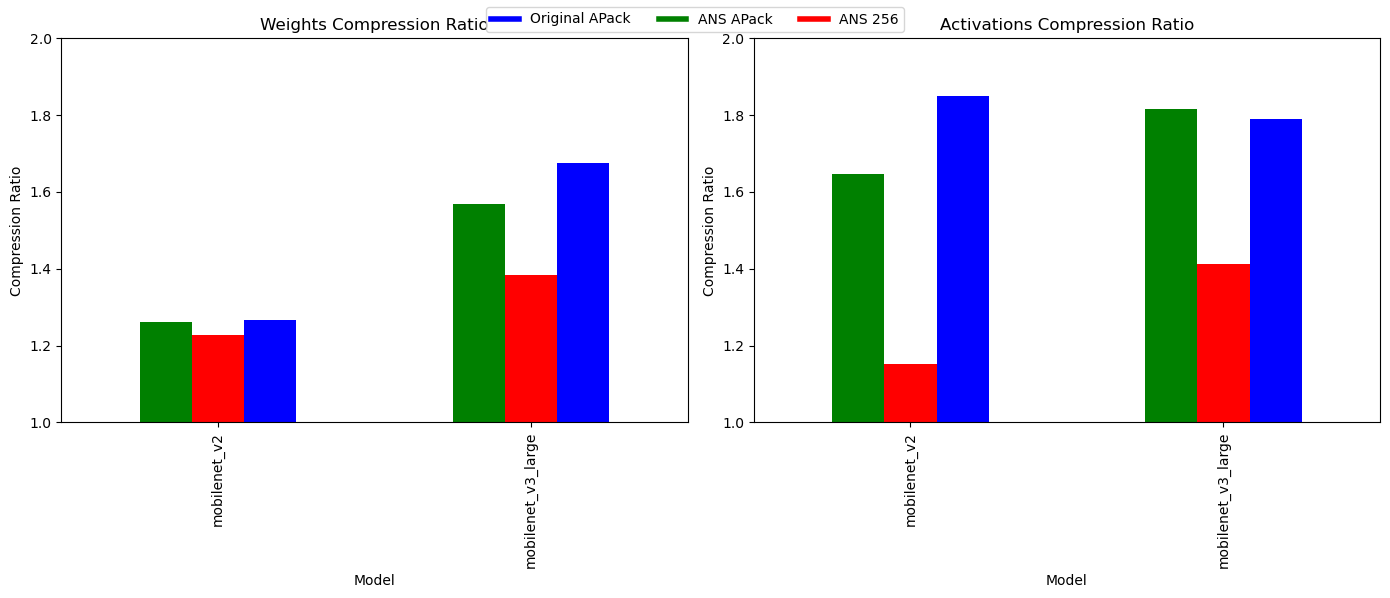

In [79]:
import matplotlib.pyplot as plt

models = ["mobilenet_v2", "mobilenet_v3_large"]
labels = ["ANS APack", "ANS 256", "AC APack"]

# Create DataFrames
df_w = pd.DataFrame({
    "Model": models,
    "w_apack": [data_frames[key]["APack"]["weights_mean"] for key in data_frames],
    "w_256": [data_frames[key]["256"]["weights_mean"] for key in data_frames],
    "w_orig": [data_frames[key]["comp"]["weights_mean"] for key in data_frames]
})

df_act = pd.DataFrame({
    "Model": models,
    "act_apack": [data_frames[key]["APack"]["activations_mean"] for key in data_frames],
    "act_256": [data_frames[key]["256"]["activations_mean"] for key in data_frames],
    "act_orig": [data_frames[key]["comp"]["activations_mean"] for key in data_frames]
})

# Define the colors for each category
color_map = {
    "Original APack": "blue",
    "ANS APack": "green",
    "ANS 256": "red"
}

# Define the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot weights compression ratio
bars_w = df_w.set_index("Model").plot(kind="bar", ax=axs[0], color=[color_map["ANS APack"], color_map["ANS 256"], color_map["Original APack"]], legend=False)
axs[0].set_title("Weights Compression Ratio")
axs[0].set_ylabel("Compression Ratio")
axs[0].set_ylim([1.0, 2])  # Set y-axis limits to zoom in

# Plot activations compression ratio
bars_act = df_act.set_index("Model").plot(kind="bar", ax=axs[1], color=[color_map["ANS APack"], color_map["ANS 256"], color_map["Original APack"]], legend=False)
axs[1].set_title("Activations Compression Ratio")
axs[1].set_ylabel("Compression Ratio")
axs[1].set_ylim([1.0, 2])  # Set y-axis limits to zoom in

# Add legend
handles = [plt.Line2D([0], [0], color=color_map[key], lw=4) for key in ["Original APack", "ANS APack", "ANS 256"]]
fig.legend(handles, color_map.keys(), loc="upper center", ncol=3)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

In [74]:
# Compute how much the compression ratio has improved with APack
print("APack/comp")
for key in data_frames:
    print(f"\t{key}:")
    print("\t\tweights:", data_frames[key]["APack"]["weights_mean"] / data_frames[key]["comp"]["weights_mean"]) 
    print("\t\tactivations",data_frames[key]["APack"]["activations_mean"] / data_frames[key]["comp"]["activations_mean"])
    
# Compute how much the compression ratio has improved with 256
print("Apack/256")
for key in data_frames:
    print(f"\t{key}:")
    print("\t\tweights:", data_frames[key]["APack"]["weights_mean"] / data_frames[key]["256"]["weights_mean"]) 
    print("\t\tactivations",data_frames[key]["APack"]["activations_mean"] / data_frames[key]["256"]["activations_mean"])

APack/comp
	trace/mobilenet_v2/:
		weights: 0.9963855822041271
		activations 0.8900037821313149
	trace/mobilenet_v3_large/:
		weights: 0.9355709130537646
		activations 1.0140085428881394
Apack/256
	trace/mobilenet_v2/:
		weights: 1.0266185070587148
		activations 1.4301124392021782
	trace/mobilenet_v3_large/:
		weights: 1.1328550879059367
		activations 1.286372161084841
